# Multi-task Learning with GCN for Graph and Node level predictions about Neighborhood Change

## Libraries Used

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!pip install torch torchvision --quiet
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

In [ ]:
# Install datacommons_pandas
!pip install datacommons_pandas --upgrade --quiet
# Import Data Commons
import datacommons_pandas as dc

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import geopandas as gpd

import json
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm  # progress bar

In [ ]:
'''Set-up GPU for use'''

gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# GPU operations have a separate seed
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Some operations on a GPU are implemented stochastic for efficiency
# Ensure that all operations are deterministic on GPU for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Is the GPU available? True
Device cuda


## Multi-task GCN Model

In [ ]:
class MultitaskGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes_node, num_classes_graph):
        super(MultitaskGCN, self).__init__()
        # Define the first GCN layer
        self.conv1 = GCNConv(num_node_features, 16)
        # Define the second GCN layer
        self.conv2 = GCNConv(16, 16)

        # MLP for node-level prediction
        self.mlp_node = torch.nn.Sequential(
            torch.nn.Linear(16, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, num_classes_node)
        )

        # MLP for graph-level prediction
        self.mlp_graph = torch.nn.Sequential(
            torch.nn.Linear(16, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, num_classes_graph)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Shared feature extraction
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)

        # Global mean pooling for graph-level features
        x_pool = global_mean_pool(x, batch)

        # Node-level prediction
        out_node = self.mlp_node(x)

        # Graph-level prediction
        out_graph = self.mlp_graph(x_pool)

        return out_node, out_graph
        # return F.log_softmax(out_node, dim=1), F.log_softmax(out_graph, dim=1)

## Training

In [ ]:
def train(model, optimizer, loader, loss_fn_node, loss_fn_graph, eta=1.0):
  model.train()
  model = model.to(device)

  epochs = 500
  loss_per_epoch = []
  for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_batches = len(loader)

    for data in loader:  # Iterate over each batch of data
      data = data.to(device)
      optimizer.zero_grad()

      out_node, out_graph = model(data)
      # print(f'Max node output: {torch.max(out_node).item()}, Max graph output: {torch.max(out_graph).item()}')

      # Node-level loss
      loss_node = loss_fn_node(out_node, data.y)

      # Graph-level loss
      loss_graph = loss_fn_graph(out_graph, data.y_graph)

      # Combine losses via a weighted sum where eta is a hyperparameter that
      loss = (eta * loss_node) + (abs(1 - eta) * loss_graph)

      # print(f'Loss: {loss.item()}')
      loss.backward()
      # print(f'Gradient norm (node): {torch.norm(next(model.parameters()).grad)}')
      optimizer.step()

      total_loss += loss.item()

    average_loss = total_loss/total_batches
    #print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')
    loss_per_epoch.append(average_loss)

  return loss_per_epoch

## Test

In [ ]:
def evaluate(model, loader):
    model.eval()
    true_labels_node = []
    predictions_node = []
    true_labels_graph = []
    predictions_graph = []

    with torch.no_grad():
        for data in loader:  # Process each batch
            data = data.to(device)
            out_node, out_graph = model(data)
            _, pred_node = out_node.max(dim=1)
            _, pred_graph = out_graph.max(dim=1)

            # Append predictions and labels for later evaluation
            true_labels_node.extend(data.y.tolist())
            predictions_node.extend(pred_node.tolist())
            true_labels_graph.extend(data.y_graph.tolist())
            predictions_graph.extend(pred_graph.tolist())

    # Calculate metrics for node-level predictions
    node_precision = precision_score(true_labels_node, predictions_node, average='macro')
    node_recall = recall_score(true_labels_node, predictions_node, average='macro')
    node_f1 = f1_score(true_labels_node, predictions_node, average='macro')

    # Calculate metrics for graph-level predictions
    graph_precision = precision_score(true_labels_graph, predictions_graph, average='macro')
    graph_recall = recall_score(true_labels_graph, predictions_graph, average='macro')
    graph_f1 = f1_score(true_labels_graph, predictions_graph, average='macro')

    # Accuracy calculations
    node_acc = sum(1 for true, pred in zip(true_labels_node, predictions_node) if true == pred) / len(true_labels_node)
    graph_acc = sum(1 for true, pred in zip(true_labels_graph, predictions_graph) if true == pred) / len(true_labels_graph)

    return {
        'Node Accuracy': node_acc,
        'Node Precision': node_precision,
        'Node Recall': node_recall,
        'Node F1-Score': node_f1,
        'Graph Accuracy': graph_acc,
        'Graph Precision': graph_precision,
        'Graph Recall': graph_recall,
        'Graph F1-Score': graph_f1
    }


In [ ]:
# def evaluate(model, loader):
#   model.eval()
#   total_correct_node = 0
#   total_nodes = 0
#   total_correct_graph = 0
#   total_graphs = 0

#   with torch.no_grad():
#     for data in loader:  # Process each batch
#       out_node, out_graph = model(data)
#       _, pred_node = out_node.max(dim=1)
#       correct_node = pred_node.eq(data.y).sum().item()
#       total_correct_node += correct_node
#       total_nodes += data.y.size(0)

#       _, pred_graph = out_graph.max(dim=1)
#       correct_graph = pred_graph.eq(data.y_graph).sum().item()
#       total_correct_graph += correct_graph
#       total_graphs += data.y_graph.size(0)

#   node_acc = total_correct_node / total_nodes
#   graph_acc = total_correct_graph / total_graphs

#   return node_acc, graph_acc

## Problem Set up: Census Data Exctraction

In [ ]:
# Function to process data for a specific year
def process_data_for_year(year, data_dict):
    result = []
    for geo_id, metrics in data_dict.items():
        row = {'GeoID': geo_id}
        if metrics['Median_Income_Household'] and metrics['Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied'] and metrics['Count_Person_EducationalAttainmentBachelorsDegreeOrHigher'] and metrics['Count_Person_WhiteAlone']:
          income_data = metrics['Median_Income_Household']['sourceSeries'][0]['val']
          if year in income_data:
              row[f'{year}_Median_Income'] = income_data[year]

          home_value_data = metrics['Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied']['sourceSeries'][0]['val']
          if year in home_value_data:
              row[f'{year}_Median_Home_Value'] = home_value_data[year]

          education_data = metrics['Count_Person_EducationalAttainmentBachelorsDegreeOrHigher']['sourceSeries'][0]['val']
          if year in education_data:
              row[f'{year}_Bachelor_Degree'] = education_data[year]

          person_data = metrics['Count_Person']['sourceSeries'][0]['val']
          if year in person_data:
              row[f'{year}_Persons'] = person_data[year]

          race_data = metrics['Count_Person_WhiteAlone']['sourceSeries'][0]['val']
          if year in race_data:
              row[f'{year}_Count_White'] = race_data[year]

          result.append(row)
    return pd.DataFrame(result)

In [ ]:
def get_features_census_tracts(df_2012,df_2019,income_percentile_40=None,home_value_percentile_40=None,education_threshold=None,home_threshold=None):
  df_2012["2012_Percentage_College"] = df_2012['2012_Bachelor_Degree']/df_2012['2012_Persons'] * 100
  df_2012["2012_Percentage_Non_White"] = (df_2012['2012_Persons'] - df_2012['2012_Count_White'])/df_2012['2012_Persons'] * 100

  df_2019["2019_Percentage_College"] = df_2019['2019_Bachelor_Degree']/df_2019['2019_Persons'] * 100
  df_2019["2019_Percentage_Non_White"] = (df_2019['2019_Persons'] - df_2019['2019_Count_White'])/df_2019['2019_Persons'] * 100

  df_final = pd.DataFrame()
  df_new = df_2012.merge(df_2019, on='GeoID')
  # df_new = df_new.dropna()

  df_final['GeoID'] = df_new['GeoID']
  df_final["Percent_Change_Income"] = (df_new['2019_Median_Income']-df_new['2012_Median_Income'])/df_new['2012_Median_Income'] * 100
  df_final["Percent_Change_Home"] = (df_new['2019_Median_Home_Value']-df_new['2012_Median_Home_Value'])/df_new['2012_Median_Home_Value'] * 100
  df_final["Percent_Change_Education"] = (df_new['2019_Percentage_College']-df_new['2012_Percentage_College'])/df_new['2012_Percentage_College'] * 100
  df_final["Percent_Change_Race"] = (df_new['2019_Percentage_Non_White']-df_new['2012_Percentage_Non_White'])/df_new['2012_Percentage_Non_White'] * 100

  if income_percentile_40 is None and home_value_percentile_40 is None:
    income_percentile_40 = df_new['2012_Median_Income'].quantile(0.4)
    home_value_percentile_40 = df_new['2012_Median_Home_Value'].quantile(0.4)

  df_final['eligible'] = ((df_new['2012_Median_Income'] <= income_percentile_40) & (df_new['2012_Median_Home_Value'] <= home_value_percentile_40)).astype(int)

  if education_threshold is None and home_threshold is None:
    education_threshold = df_final['Percent_Change_Education'].quantile(2/3)
    home_threshold = df_final['Percent_Change_Home'].quantile(2/3)

  df_final['label'] = ((df_final['Percent_Change_Education'] > education_threshold) & (df_final['Percent_Change_Home'] > home_threshold) & df_final['eligible'] == 1).astype(int)
  return df_final, income_percentile_40, home_value_percentile_40, education_threshold, home_threshold

### Census tract extraction

In [ ]:
# Davidson County
county = 'geoId/47037'

In [ ]:
# Get lists of census tracts within the County, respectively.
census_tracts = dc.get_places_in([county], 'CensusTract')[county]
print(census_tracts)

['geoId/47037010103', 'geoId/47037010104', 'geoId/47037010105', 'geoId/47037010106', 'geoId/47037010201', 'geoId/47037010202', 'geoId/47037010301', 'geoId/47037010302', 'geoId/47037010303', 'geoId/47037010401', 'geoId/47037010402', 'geoId/47037010501', 'geoId/47037010502', 'geoId/47037010601', 'geoId/47037010602', 'geoId/47037010701', 'geoId/47037010702', 'geoId/47037010801', 'geoId/47037010802', 'geoId/47037010901', 'geoId/47037010903', 'geoId/47037010904', 'geoId/47037011001', 'geoId/47037011002', 'geoId/47037011100', 'geoId/47037011200', 'geoId/47037011300', 'geoId/47037011400', 'geoId/47037011500', 'geoId/47037011600', 'geoId/47037011700', 'geoId/47037011800', 'geoId/47037011900', 'geoId/47037012100', 'geoId/47037012200', 'geoId/47037012600', 'geoId/47037012701', 'geoId/47037012702', 'geoId/47037012801', 'geoId/47037012802', 'geoId/47037013000', 'geoId/47037013100', 'geoId/47037013201', 'geoId/47037013202', 'geoId/47037013300', 'geoId/47037013400', 'geoId/47037013500', 'geoId/47037

In [ ]:
stats = dc.get_stat_all(census_tracts, ["Median_Income_Household","Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied", "Count_Person_EducationalAttainmentBachelorsDegreeOrHigher", 'Count_Person_WhiteAlone',"Count_Person"])
print(stats)

{'geoId/47037017200': {'Median_Income_Household': {'sourceSeries': [{'val': {'2013': 37147, '2012': 35846, '2018': 41463, '2022': 79375, '2020': 61422, '2014': 36786, '2015': 36990, '2016': 38869, '2017': 37955, '2019': 53148, '2021': 68992, '2011': 37404}, 'measurementMethod': 'CensusACS5yrSurvey', 'importName': 'CensusACS5YearSurvey', 'provenanceDomain': 'census.gov', 'unit': 'USDollar', 'provenanceUrl': 'https://www.census.gov/programs-surveys/acs/data/data-via-ftp.html'}]}, 'Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied': {'sourceSeries': [{'val': {'2016': 160800, '2022': 330300, '2017': 185500, '2014': 123000, '2015': 120100, '2021': 238000, '2018': 200600, '2020': 211700, '2013': 108600, '2011': 110000, '2019': 212400, '2012': 110300}, 'measurementMethod': 'CensusACS5yrSurvey', 'importName': 'CensusACS5YearSurvey', 'provenanceDomain': 'census.gov', 'unit': 'USDollar', 'provenanceUrl': 'https://www.census.gov/programs-surveys/acs/data/data-via-ftp.html'}]}, 'Count

In [ ]:
geo_ids = list(stats.keys())
len(geo_ids)        # aka num of census tracts

161

In [ ]:
# Create DataFrames for each year
df_2012 = process_data_for_year('2012', stats)
df_2019 = process_data_for_year('2019', stats)

# Get Features
df_census_tracts, ip4,hp4,ep,hp = get_features_census_tracts(df_2012,df_2019)
df_census_tracts

,GeoID,Percent_Change_Income,Percent_Change_Home,Percent_Change_Education,Percent_Change_Race,eligible,label
0,geoId/47037017200,48.267589,92.565730,67.918436,-55.634737,1,1
1,geoId/47037019109,10.176260,29.946524,16.073725,-28.140050,0,0
2,geoId/47037010103,-13.334730,19.810825,-19.661868,-82.013218,0,0
3,geoId/47037011500,26.915114,91.578947,138.016008,-40.562164,0,0
4,geoId/47037015404,20.588919,22.812052,31.058197,24.699139,0,0
...,...,...,...,...,...,...,...
152,geoId/47037015612,27.246010,13.390313,13.200016,13.089933,0,0
153,geoId/47037017100,49.284014,92.011834,66.672716,-66.034613,0,0
154,geoId/47037018101,15.979927,51.336574,-4.792272,0.317318,0,0
155,geoId/47037018904,94.173218,40.337838,74.488238,-12.722891,0,0


In [ ]:
df_2012.head()

,GeoID,2012_Median_Income,2012_Median_Home_Value,2012_Bachelor_Degree,2012_Persons,2012_Count_White,2012_Percentage_College,2012_Percentage_Non_White
0,geoId/47037018101,33079,164600.0,1085,4776,2527,22.717755,47.089615
1,geoId/47037018601,163250,746300.0,1094,2194,2053,49.863263,6.426618
2,geoId/47037010105,55241,156800.0,1227,4255,808,28.836663,81.010576
3,geoId/47037010501,30075,116400.0,697,4975,4414,14.010050,11.276382
4,geoId/47037015609,47830,157300.0,900,3215,2424,27.993779,24.603421


### Census block group extraction

In [ ]:
count = 0
block_groups = {}
for ct in census_tracts:
  blocks = dc.get_places_in([ct], 'CensusBlockGroup')[ct]
  stats = dc.get_stat_all(blocks, ["Median_Income_Household","Median_HomeValue_HousingUnit_OccupiedHousingUnit_OwnerOccupied", "Count_Person_EducationalAttainmentBachelorsDegreeOrHigher", 'Count_Person_WhiteAlone',"Count_Person"])
  df_2012 = process_data_for_year('2012', stats)
  df_2019 = process_data_for_year('2019', stats)
  try:
    df_final, _,_,_,_ = get_features_census_tracts(df_2012,df_2019,ip4,hp4,ep,hp)
    block_groups[ct] = df_final
  except:
    print("block group data empty for ct: ", ct)

block group data empty for ct:  geoId/47037013000
block group data empty for ct:  geoId/47037013602
block group data empty for ct:  geoId/47037014400
block group data empty for ct:  geoId/47037014800
block group data empty for ct:  geoId/47037016500
block group data empty for ct:  geoId/47037980100
block group data empty for ct:  geoId/47037980200


In [ ]:
with open('./block_groups_nash.pkl', 'wb') as file:
    pickle.dump(block_groups, file)

In [ ]:
print(block_groups.keys())

dict_keys(['geoId/47037010103', 'geoId/47037010104', 'geoId/47037010105', 'geoId/47037010106', 'geoId/47037010201', 'geoId/47037010202', 'geoId/47037010301', 'geoId/47037010302', 'geoId/47037010303', 'geoId/47037010401', 'geoId/47037010402', 'geoId/47037010501', 'geoId/47037010502', 'geoId/47037010601', 'geoId/47037010602', 'geoId/47037010701', 'geoId/47037010702', 'geoId/47037010801', 'geoId/47037010802', 'geoId/47037010901', 'geoId/47037010903', 'geoId/47037010904', 'geoId/47037011001', 'geoId/47037011002', 'geoId/47037011100', 'geoId/47037011200', 'geoId/47037011300', 'geoId/47037011400', 'geoId/47037011500', 'geoId/47037011600', 'geoId/47037011700', 'geoId/47037011800', 'geoId/47037011900', 'geoId/47037012100', 'geoId/47037012200', 'geoId/47037012600', 'geoId/47037012701', 'geoId/47037012702', 'geoId/47037012801', 'geoId/47037012802', 'geoId/47037013100', 'geoId/47037013201', 'geoId/47037013202', 'geoId/47037013300', 'geoId/47037013400', 'geoId/47037013500', 'geoId/47037013601', 'g

### Extract Edge Attributes

In [ ]:
tn = gpd.read_file('./tl_2023_47_bg.shp')
gdf = tn[tn.COUNTYFP=='037']
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
399,47,037,010802,3,470370108023,1500000US470370108023,Block Group 3,G5030,S,1813377,0,+36.2598645,-086.7278936,"POLYGON ((-86.73841 36.25559, -86.73835 36.255..."
415,47,037,010802,2,470370108022,1500000US470370108022,Block Group 2,G5030,S,1202812,0,+36.2521693,-086.7301290,"POLYGON ((-86.74129 36.25003, -86.74108 36.250..."
421,47,037,010901,1,470370109011,1500000US470370109011,Block Group 1,G5030,S,2879560,0,+36.2691434,-086.7681851,"POLYGON ((-86.78310 36.27836, -86.78275 36.278..."
458,47,037,011001,5,470370110015,1500000US470370110015,Block Group 5,G5030,S,871215,0,+36.2158089,-086.7533039,"POLYGON ((-86.76221 36.22023, -86.76219 36.220..."
459,47,037,011001,2,470370110012,1500000US470370110012,Block Group 2,G5030,S,2053638,0,+36.2161318,-086.7692163,"POLYGON ((-86.77646 36.20665, -86.77641 36.207..."


In [ ]:
# # Ensure the blocks are within the same tract if you have multiple tracts
# Load in block groups here
with open('./block_groups_nash.pkl', 'rb') as file:
    block_groups = pickle.load(file)

edge_attr = {}
# keys = ['geoId/47037010103', 'geoId/47037010104', 'geoId/47037010105', 'geoId/47037010106', 'geoId/47037010201', 'geoId/47037010202', 'geoId/47037010301', 'geoId/47037010302', 'geoId/47037010303', 'geoId/47037010401', 'geoId/47037010402', 'geoId/47037010501', 'geoId/47037010502', 'geoId/47037010601', 'geoId/47037010602', 'geoId/47037010701', 'geoId/47037010702', 'geoId/47037010801', 'geoId/47037010802', 'geoId/47037010901', 'geoId/47037010903', 'geoId/47037010904', 'geoId/47037011001', 'geoId/47037011002', 'geoId/47037011100', 'geoId/47037011200', 'geoId/47037011300', 'geoId/47037011400', 'geoId/47037011500', 'geoId/47037011600', 'geoId/47037011700', 'geoId/47037011800', 'geoId/47037011900', 'geoId/47037012100', 'geoId/47037012200', 'geoId/47037012600', 'geoId/47037012701', 'geoId/47037012702', 'geoId/47037012801', 'geoId/47037012802', 'geoId/47037013100', 'geoId/47037013201', 'geoId/47037013202', 'geoId/47037013300', 'geoId/47037013400', 'geoId/47037013500', 'geoId/47037013601', 'geoId/47037013602', 'geoId/47037013700', 'geoId/47037013800', 'geoId/47037013900', 'geoId/47037014200', 'geoId/47037014300', 'geoId/47037015100', 'geoId/47037015200', 'geoId/47037015300', 'geoId/47037015401', 'geoId/47037015402', 'geoId/47037015404', 'geoId/47037015405', 'geoId/47037015501', 'geoId/47037015502', 'geoId/47037015609', 'geoId/47037015610', 'geoId/47037015612', 'geoId/47037015613', 'geoId/47037015614', 'geoId/47037015615', 'geoId/47037015617', 'geoId/47037015618', 'geoId/47037015619', 'geoId/47037015620', 'geoId/47037015622', 'geoId/47037015623', 'geoId/47037015624', 'geoId/47037015625', 'geoId/47037015626', 'geoId/47037015627', 'geoId/47037015628', 'geoId/47037015629', 'geoId/47037015630', 'geoId/47037015631', 'geoId/47037015700', 'geoId/47037015802', 'geoId/47037015803', 'geoId/47037015804', 'geoId/47037015900', 'geoId/47037016000', 'geoId/47037016100', 'geoId/47037016200', 'geoId/47037016300', 'geoId/47037016400', 'geoId/47037016600', 'geoId/47037016700', 'geoId/47037016800', 'geoId/47037016900', 'geoId/47037017000', 'geoId/47037017100', 'geoId/47037017200', 'geoId/47037017300', 'geoId/47037017401', 'geoId/47037017402', 'geoId/47037017500', 'geoId/47037017701', 'geoId/47037017702', 'geoId/47037017800', 'geoId/47037017901', 'geoId/47037017902', 'geoId/47037018000', 'geoId/47037018101', 'geoId/47037018102', 'geoId/47037018201', 'geoId/47037018202', 'geoId/47037018203', 'geoId/47037018301', 'geoId/47037018302', 'geoId/47037018401', 'geoId/47037018404', 'geoId/47037018405', 'geoId/47037018407', 'geoId/47037018408', 'geoId/47037018409', 'geoId/47037018410', 'geoId/47037018500', 'geoId/47037018601', 'geoId/47037018602', 'geoId/47037018700', 'geoId/47037018801', 'geoId/47037018803', 'geoId/47037018804', 'geoId/47037018901', 'geoId/47037018902', 'geoId/47037018904', 'geoId/47037018905', 'geoId/47037019003', 'geoId/47037019004', 'geoId/47037019005', 'geoId/47037019006', 'geoId/47037019105', 'geoId/47037019106', 'geoId/47037019108', 'geoId/47037019109', 'geoId/47037019110', 'geoId/47037019111', 'geoId/47037019112', 'geoId/47037019114', 'geoId/47037019115', 'geoId/47037019116', 'geoId/47037019117', 'geoId/47037019118', 'geoId/47037019200', 'geoId/47037019300', 'geoId/47037019400', 'geoId/47037019500', 'geoId/47037019600']
# keys = ['geoId/47037010103', 'geoId/47037010104', 'geoId/47037010105', 'geoId/47037010106', 'geoId/47037010201', 'geoId/47037010202', 'geoId/47037010301', 'geoId/47037010302', 'geoId/47037010303', 'geoId/47037010401', 'geoId/47037010402', 'geoId/47037010501', 'geoId/47037010502', 'geoId/47037010601', 'geoId/47037010602', 'geoId/47037010701', 'geoId/47037010702', 'geoId/47037010801', 'geoId/47037010802', 'geoId/47037010901', 'geoId/47037010903', 'geoId/47037010904', 'geoId/47037011001', 'geoId/47037011002', 'geoId/47037011100', 'geoId/47037011200', 'geoId/47037011300', 'geoId/47037011400', 'geoId/47037011500', 'geoId/47037011600', 'geoId/47037011700', 'geoId/47037011800', 'geoId/47037011900', 'geoId/47037012100', 'geoId/47037012200', 'geoId/47037012600', 'geoId/47037012701', 'geoId/47037012702', 'geoId/47037012801', 'geoId/47037012802', 'geoId/47037013100', 'geoId/47037013201', 'geoId/47037013202', 'geoId/47037013300', 'geoId/47037013400', 'geoId/47037013500', 'geoId/47037013601', 'geoId/47037013700', 'geoId/47037013800', 'geoId/47037013900', 'geoId/47037014200', 'geoId/47037014300', 'geoId/47037015100', 'geoId/47037015200', 'geoId/47037015300', 'geoId/47037015401', 'geoId/47037015402', 'geoId/47037015404', 'geoId/47037015405', 'geoId/47037015501', 'geoId/47037015502', 'geoId/47037015609', 'geoId/47037015610', 'geoId/47037015612', 'geoId/47037015613', 'geoId/47037015614', 'geoId/47037015615', 'geoId/47037015617', 'geoId/47037015618', 'geoId/47037015619', 'geoId/47037015620', 'geoId/47037015622', 'geoId/47037015623', 'geoId/47037015624', 'geoId/47037015625', 'geoId/47037015626', 'geoId/47037015627', 'geoId/47037015628', 'geoId/47037015629', 'geoId/47037015630', 'geoId/47037015631', 'geoId/47037015700', 'geoId/47037015802', 'geoId/47037015803', 'geoId/47037015804', 'geoId/47037015900', 'geoId/47037016000', 'geoId/47037016100', 'geoId/47037016200', 'geoId/47037016300', 'geoId/47037016400', 'geoId/47037016600', 'geoId/47037016700', 'geoId/47037016800', 'geoId/47037016900', 'geoId/47037017000', 'geoId/47037017100', 'geoId/47037017200', 'geoId/47037017300', 'geoId/47037017401', 'geoId/47037017402', 'geoId/47037017500', 'geoId/47037017701', 'geoId/47037017702', 'geoId/47037017800', 'geoId/47037017901', 'geoId/47037017902', 'geoId/47037018000', 'geoId/47037018101', 'geoId/47037018102', 'geoId/47037018201', 'geoId/47037018202', 'geoId/47037018203', 'geoId/47037018301', 'geoId/47037018302', 'geoId/47037018401', 'geoId/47037018404', 'geoId/47037018405', 'geoId/47037018407', 'geoId/47037018408', 'geoId/47037018409', 'geoId/47037018410', 'geoId/47037018500', 'geoId/47037018601', 'geoId/47037018602', 'geoId/47037018700', 'geoId/47037018801', 'geoId/47037018803', 'geoId/47037018804', 'geoId/47037018901', 'geoId/47037018902', 'geoId/47037018904', 'geoId/47037018905', 'geoId/47037019003', 'geoId/47037019004', 'geoId/47037019005', 'geoId/47037019006', 'geoId/47037019105', 'geoId/47037019106', 'geoId/47037019108', 'geoId/47037019109', 'geoId/47037019110', 'geoId/47037019111', 'geoId/47037019112', 'geoId/47037019114', 'geoId/47037019115', 'geoId/47037019116', 'geoId/47037019117', 'geoId/47037019118', 'geoId/47037019200', 'geoId/47037019300', 'geoId/47037019400', 'geoId/47037019500', 'geoId/47037019600']
for k in block_groups.keys():
    numerical_id = k.split('/')[1][-6:]
    gdf_new = gdf[gdf['TRACTCE'] == numerical_id]

    df = block_groups[k]
    df['GEOID'] = df['GeoID'].apply(lambda x: x.split('/')[-1])  # Remove the prefix "geoId/"
    result = gpd.GeoDataFrame(pd.merge(df, gdf_new, on='GEOID', how='inner'))

    # Generate the neighbors list based on shared boundaries
    neighbors = []
    for i, geom_i in enumerate(result.geometry):
        for j, geom_j in enumerate(result.geometry):
            if i != j and geom_i.touches(geom_j):  # Check if two geometries are neighbors
                neighbors.append((i, j))

    # Remove duplicate pairs
    neighbors = list(set(map(frozenset, neighbors)))
    neighbors = [tuple(pair) for pair in neighbors]

    edge_attr[k] = neighbors

In [ ]:
print(edge_attr)
with open('edge_attr_nash.pkl', 'wb') as file:
    pickle.dump(edge_attr, file)

{'geoId/47037010103': [(0, 1)], 'geoId/47037010104': [(0, 1)], 'geoId/47037010105': [(0, 1), (0, 2), (1, 2)], 'geoId/47037010106': [(0, 1)], 'geoId/47037010201': [(0, 1), (0, 2), (1, 2)], 'geoId/47037010202': [(0, 1), (0, 2), (1, 2)], 'geoId/47037010301': [(0, 1)], 'geoId/47037010302': [(0, 1)], 'geoId/47037010303': [(0, 2), (1, 2)], 'geoId/47037010401': [(0, 1), (0, 2), (1, 2)], 'geoId/47037010402': [], 'geoId/47037010501': [(3, 4), (1, 4), (2, 3), (1, 2), (0, 3), (0, 1), (0, 2), (0, 4)], 'geoId/47037010502': [(0, 1), (0, 2), (1, 2)], 'geoId/47037010601': [(2, 3), (0, 3), (0, 1), (0, 2), (1, 3)], 'geoId/47037010602': [(0, 1)], 'geoId/47037010701': [(2, 3), (1, 2), (0, 3), (0, 1), (0, 2)], 'geoId/47037010702': [(0, 1)], 'geoId/47037010801': [(0, 2), (1, 2)], 'geoId/47037010802': [(0, 1), (0, 2)], 'geoId/47037010901': [(0, 1)], 'geoId/47037010903': [(0, 1), (1, 2)], 'geoId/47037010904': [(0, 1)], 'geoId/47037011001': [(3, 4), (2, 3), (1, 2), (0, 3), (0, 1), (0, 4), (1, 3)], 'geoId/47037

## Data prep for Training and Testing

In [ ]:
# Load in edge attributes
with open('./edge_attr_nash.pkl', 'rb') as file:
  edge_attr = pickle.load(file)

data_list = []
graph_labels_list = []

for id in block_groups.keys():
  features = block_groups[id][['Percent_Change_Income', 'Percent_Change_Home', 'Percent_Change_Education', 'Percent_Change_Race']].to_numpy()

  node_features = torch.tensor(features, dtype=torch.float)
  neighbors = edge_attr[id]

  if neighbors and max(max(neighbors)) < len(features):
    edge_index = torch.tensor(neighbors, dtype=torch.long).t().contiguous()

    # Node-level labels and a graph-level label
    node_labels = torch.tensor(block_groups[id]['label'].values)  # binary labels for node-level task
    graph_label = torch.tensor([df_census_tracts[df_census_tracts['GeoID'] == id]['label'].iloc[0]], dtype=torch.long)

    # PyTorch Geometric Data object
    data = Data(x=node_features, edge_index=edge_index, y=node_labels)
    data.y_graph = graph_label  # Add graph-level label as an additional attribute
    data_list.append(data)

cleaned_data_list = []
for data in data_list:
  if torch.isnan(data.x).any() or torch.isnan(data.y).any() or torch.isinf(data.x).any() or torch.isinf(data.y).any():
    continue  # Skip this Data object
  cleaned_data_list.append(data)

# Data object has a y_graph attribute that represents the graph-level label
graph_labels = [data.y_graph.item() for data in cleaned_data_list]

In [ ]:
len(data_list)

131

In [ ]:
len(cleaned_data_list)

75

### Training Test Split

In [ ]:
train_data, test_data = train_test_split(cleaned_data_list, test_size=0.1, stratify=graph_labels)

# Create a DataLoader to batch Data objects
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data,batch_size=16,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



## Run Experiments for task weighting

In [ ]:
etas = [1.0, 0.8, 0.6, 0.5, 0.4, 0.2, 0.0]
loss_fn_node = torch.nn.CrossEntropyLoss()  # For node-level classification
loss_fn_graph = torch.nn.CrossEntropyLoss()  # For graph-level classification

for eta in etas:

    # Train model with given eta
    model = MultitaskGCN(num_node_features=4, num_classes_node=2, num_classes_graph=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_per_epoch = train(model, optimizer, train_loader, loss_fn_node, loss_fn_graph, eta)

    # Save Training results
    with open(f'train_results_eta_{eta}.pkl', 'wb') as f:
        pickle.dump(loss_per_epoch, f)

    # Evaluate Model
    results_dict = evaluate(model, test_loader)
    node_acc = results_dict['Node Accuracy']
    graph_acc = results_dict['Graph Accuracy']
    #print(f'Node-level Accuracy: {node_acc:.4f}, Graph-level Accuracy: {graph_acc:.4f}')

    # Save results from evaluate
    with open(f'eval_results_eta_{eta}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)

    # Release tensors on GPU
    del model, optimizer
    torch.cuda.empty_cache()


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# load training results from pickle files
experiments = []
with open('train_results_eta_0.0.pkl', 'rb') as f:
    train_loss_eta_graph_only = pickle.load(f)
    experiments.append((0.0, train_loss_eta_graph_only))

with open('train_results_eta_0.2.pkl', 'rb') as f:
    train_loss_eta_20_80 = pickle.load(f)
    experiments.append((0.2, train_loss_eta_20_80))

with open('train_results_eta_0.4.pkl', 'rb') as f:
    train_loss_eta_40_60 = pickle.load(f)
    experiments.append((0.4, train_loss_eta_40_60))

with open('train_results_eta_0.5.pkl', 'rb') as f:
    train_loss_eta_equal = pickle.load(f)
    experiments.append((0.5, train_loss_eta_equal))

with open('train_results_eta_0.6.pkl', 'rb') as f:
    train_loss_eta_60_40 = pickle.load(f)
    experiments.append((0.6, train_loss_eta_60_40))

with open('train_results_eta_0.8.pkl', 'rb') as f:
    train_loss_eta_80_20 = pickle.load(f)
    experiments.append((0.8, train_loss_eta_80_20))

with open('train_results_eta_1.0.pkl', 'rb') as f:
    train_loss_eta_node_only = pickle.load(f)
    experiments.append((1.0, train_loss_eta_node_only))

In [ ]:
best_eta = 0.0
best_avg_loss = 100000000
moving_avgs = []
for i, exp in experiments:
    cumulative_sum = np.cumsum(exp)
    cumulative_avg = []
    for j in range(1,501):
        cumulative_avg.append(cumulative_sum[j-1]/float(j))
    moving_avgs.append(cumulative_avg)
    avg_loss = cumulative_avg[-1]
    print(i, ": ", avg_loss)

    if avg_loss < best_avg_loss:
        best_eta = i
        best_avg_loss = avg_loss

print(f'Best eta: {best_eta}, Best Average Loss: {best_avg_loss}')


0.0 :  0.017173591272277616
0.2 :  0.06047539994372964
0.4 :  0.053536614842954876
0.5 :  0.0742027733609527
0.6 :  0.07643963544177615
0.8 :  0.07052005136727092
1.0 :  0.09325685235021887
Best eta: 0.0, Best Average Loss: 0.017173591272277616


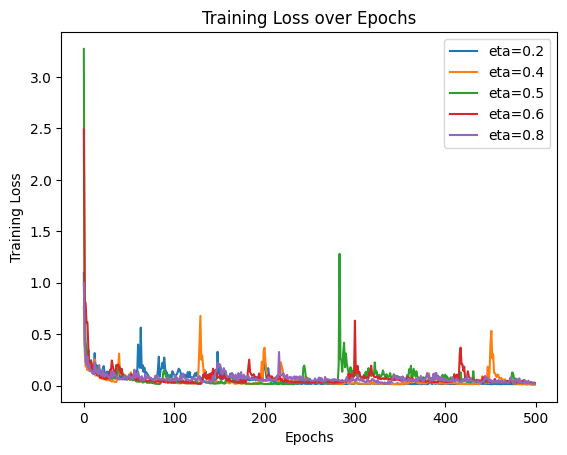

In [ ]:
plt.plot(np.arange(500), train_loss_eta_20_80, label='eta=0.2')
plt.plot(np.arange(500), train_loss_eta_40_60, label='eta=0.4')
plt.plot(np.arange(500), train_loss_eta_equal, label='eta=0.5')
plt.plot(np.arange(500), train_loss_eta_60_40, label='eta=0.6')
plt.plot(np.arange(500), train_loss_eta_80_20, label='eta=0.8')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

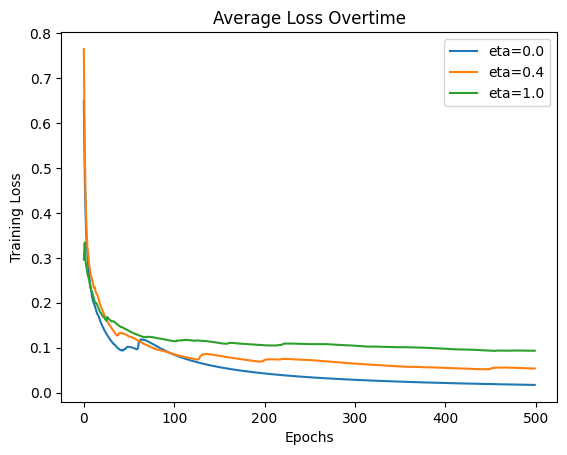

In [ ]:
# Compare best MTL with STL
labels = ['eta=0.0', 'eta=0.4', 'eta=1.0']
y_s = [moving_avgs[0], moving_avgs[2], moving_avgs[6]]
epochs = np.arange(500)

for i in range(len(labels)):
    plt.plot(epochs, y_s[i], label=labels[i])

plt.title('Average Loss Overtime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

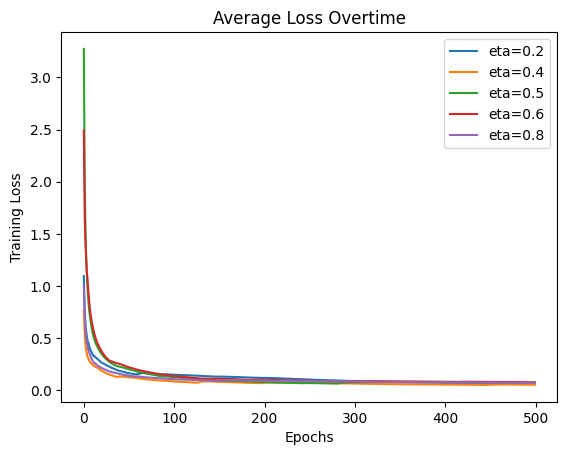

In [ ]:
# Compare All eta values
labels = ['eta=0.2', 'eta=0.4', 'eta=0.5', 'eta=0.6', 'eta=0.8']
y_s = [moving_avgs[1], moving_avgs[2], moving_avgs[3], moving_avgs[4], moving_avgs[5]]
epochs = np.arange(500)

for i in range(len(labels)):
    plt.plot(epochs, y_s[i], label=labels[i])

plt.title('Average Loss Overtime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
# load evaluation results from pickle files
experiments = []
with open('eval_results_eta_0.0.pkl', 'rb') as f:
    test_loss_eta_graph_only = pickle.load(f)
    experiments.append((0.0, test_loss_eta_graph_only))

with open('eval_results_eta_0.2.pkl', 'rb') as f:
    test_loss_eta_20_80 = pickle.load(f)
    experiments.append((0.2, test_loss_eta_20_80))

with open('eval_results_eta_0.4.pkl', 'rb') as f:
    test_loss_eta_40_60 = pickle.load(f)
    experiments.append((0.4, test_loss_eta_40_60))

with open('eval_results_eta_0.5.pkl', 'rb') as f:
    test_loss_eta_equal = pickle.load(f)
    experiments.append((0.5, test_loss_eta_equal))

with open('eval_results_eta_0.6.pkl', 'rb') as f:
    test_loss_eta_60_40 = pickle.load(f)
    experiments.append((0.6, test_loss_eta_60_40))

with open('eval_results_eta_0.8.pkl', 'rb') as f:
    test_loss_eta_80_20 = pickle.load(f)
    experiments.append((0.8, test_loss_eta_80_20))

with open('eval_results_eta_1.0.pkl', 'rb') as f:
    test_loss_eta_node_only = pickle.load(f)
    experiments.append((1.0, test_loss_eta_node_only))

In [ ]:
print(experiments)

[(0.0, {'Node Accuracy': 0.5217391304347826, 'Node Precision': 0.5416666666666666, 'Node Recall': 0.75, 'Node F1-Score': 0.41025641025641024, 'Graph Accuracy': 0.625, 'Graph Precision': 0.4166666666666667, 'Graph Recall': 0.35714285714285715, 'Graph F1-Score': 0.3846153846153846}), (0.2, {'Node Accuracy': 0.9130434782608695, 'Node Precision': 0.4772727272727273, 'Node Recall': 0.4772727272727273, 'Node F1-Score': 0.4772727272727273, 'Graph Accuracy': 0.75, 'Graph Precision': 0.42857142857142855, 'Graph Recall': 0.42857142857142855, 'Graph F1-Score': 0.42857142857142855}), (0.4, {'Node Accuracy': 0.9565217391304348, 'Node Precision': 0.4782608695652174, 'Node Recall': 0.5, 'Node F1-Score': 0.4888888888888889, 'Graph Accuracy': 0.875, 'Graph Precision': 0.75, 'Graph Recall': 0.9285714285714286, 'Graph F1-Score': 0.7948717948717948}), (0.5, {'Node Accuracy': 0.9130434782608695, 'Node Precision': 0.4772727272727273, 'Node Recall': 0.4772727272727273, 'Node F1-Score': 0.4772727272727273, 'G

In [ ]:
# Create table for testing results
columns = [key for key in experiments[0][1].keys()]
columns.insert(0, 'eta')
results_df = pd.DataFrame(columns=columns)

for i, exp in experiments:
    exp['eta'] = i
    #results_df = results_df.append(exp, ignore_index=True)
    results_df = pd.concat([results_df, pd.DataFrame(exp)], ignore_index=True)

print(results_df)


{'Node Accuracy': 0.5217391304347826, 'Node Precision': 0.5416666666666666, 'Node Recall': 0.75, 'Node F1-Score': 0.41025641025641024, 'Graph Accuracy': 0.625, 'Graph Precision': 0.4166666666666667, 'Graph Recall': 0.35714285714285715, 'Graph F1-Score': 0.3846153846153846, 'eta': 0.0}


ValueError: If using all scalar values, you must pass an index